<a href="https://colab.research.google.com/github/ashhdubey/KNN-Classification-on-Iris-Dataset-project/blob/main/KNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)

# Fix random seed for reproducibility
np.random.seed(42)


In [ ]:
# Load iris dataset
iris = datasets.load_iris()
X_full = iris.data
y_full = iris.target
feature_names_full = iris.feature_names
target_names = iris.target_names

# Keep only classes 0 (setosa) and 1 (versicolor)
mask = y_full < 2
X_2c = X_full[mask]
y_2c = y_full[mask]

# Pick any two features (example: sepal length, petal length)
feat_idx = [0, 2]
X = X_2c[:, feat_idx]
chosen_features = [feature_names_full[i] for i in feat_idx]

# Build DataFrame
df = pd.DataFrame(X, columns=chosen_features)
df['target'] = y_2c
df['target_name'] = df['target'].map({0: target_names[0], 1: target_names[1]})

# Show head
print("Chosen features:", chosen_features)
print("Target names:", list(target_names[:2]))
df.head()


Chosen features: ['sepal length (cm)', 'petal length (cm)']
Target names: [np.str_('setosa'), np.str_('versicolor')]


,sepal length (cm),petal length (cm),target,target_name
0,5.1,1.4,0,setosa
1,4.9,1.4,0,setosa
2,4.7,1.3,0,setosa
3,4.6,1.5,0,setosa
4,5.0,1.4,0,setosa


In [ ]:
# Train/test split: 30% test, stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y_2c, test_size=0.3, stratify=y_2c, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Quick checks
print("Train shape:", X_train_scaled.shape, " Test shape:", X_test_scaled.shape)
print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))



Train shape: (70, 2)  Test shape: (30, 2)
Train class counts: [35 35]
Test  class counts: [15 15]


In [ ]:
# Train initial KNN (k=5, uniform weights)
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train_scaled, y_train)

# Print hyperparameters
print("KNN hyperparameters:")
print(" n_neighbors:", knn.n_neighbors)
print(" metric    :", knn.metric)
print(" weights   :", knn.weights)

# Predict
y_pred = knn.predict(X_test_scaled)


KNN hyperparameters:
 n_neighbors: 5
 metric    : minkowski
 weights   : uniform


In [ ]:
# Compute metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

# Show results
print(f"\nTest metrics with k=5:")
print(f" Accuracy : {acc:.3f}")
print(f" Precision: {prec:.3f}")
print(f" Recall   : {rec:.3f}")
print(f" F1       : {f1:.3f}")



Test metrics with k=5:
 Accuracy : 1.000
 Precision: 1.000
 Recall   : 1.000
 F1       : 1.000


<Figure size 500x300 with 0 Axes>

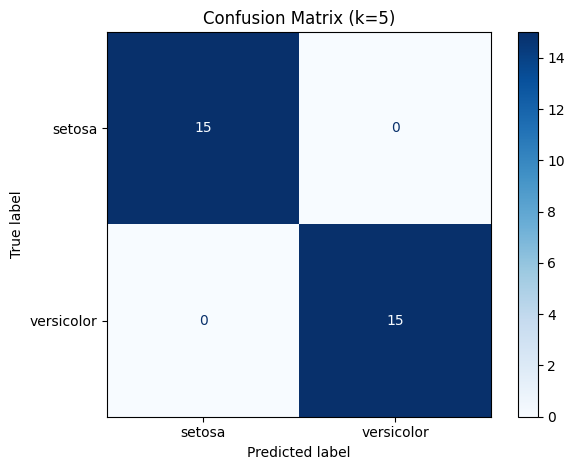

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[target_names[0], target_names[1]])

plt.figure(figsize=(5,3))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (k=5)")
plt.tight_layout()
plt.show()


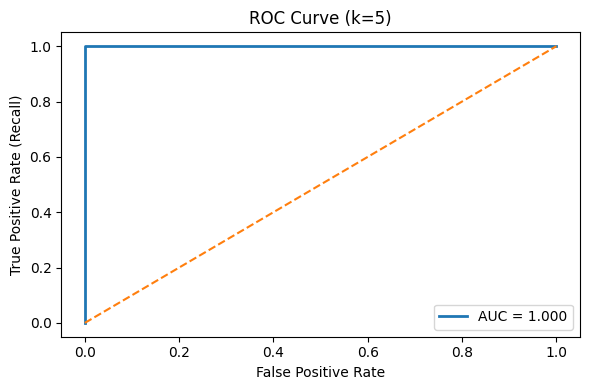

AUC: 1.000
Summary: AUC closer to 1.0 means better ranking of positives vs negatives. 0.5 means random.


In [ ]:
# Predicted probabilities
y_score = knn.predict_proba(X_test_scaled)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# Plot
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (k=5)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUC: {auc:.3f}")
print("Summary: AUC closer to 1.0 means better ranking of positives vs negatives. 0.5 means random.")


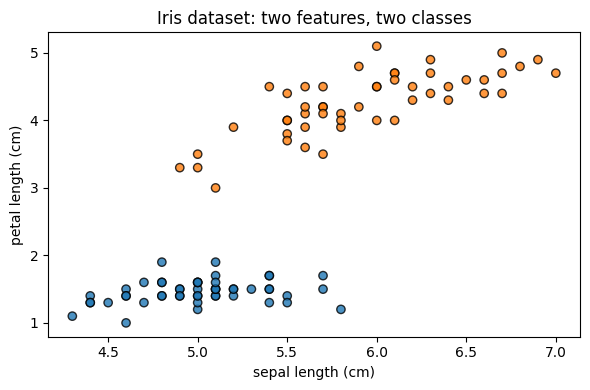

In [ ]:
# Simple scatter plot
colors = np.array(['tab:blue', 'tab:orange'])
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], c=colors[y_2c], edgecolor='k', alpha=0.8)
plt.xlabel(chosen_features[0])
plt.ylabel(chosen_features[1])
plt.title("Iris dataset: two features, two classes")
plt.tight_layout()
plt.show()


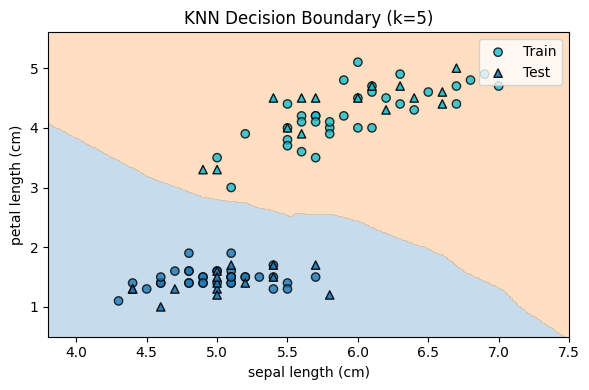

In [ ]:
# Function to plot decision boundary
def plot_knn_decision_boundary(model, scaler, X_train, X_test, y_train, y_test, feature_names, title="KNN Decision Boundary"):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    Z = model.predict(grid_scaled).reshape(xx.shape)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5,0.5,1.5], colors=['tab:blue','tab:orange'])
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='tab10', edgecolor='k', label='Train', alpha=0.8)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='tab10', edgecolor='k', marker='^', label='Test', alpha=0.9)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Call the function
plot_knn_decision_boundary(knn, scaler, X_train, X_test, y_train, y_test, chosen_features,
                           title="KNN Decision Boundary (k=5)")
